In [178]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

# <center> First attempt on simulating Coded Aperture </center>

This notebook is a first attempt on simulating light coming out of a screen as single photons, passing through a single hole, projecting onto a flat sensor.

The degrees of fredom would be:
1. Distance between each screen
2. Solid angle limits of emision (for now, we fix it at 360 for $\theta$, and 90 for $\phi$)
3. Number of photons coming out of each pixel
4. Resolution: Number of pixels on the light source
5. Dimention of each screen

For now, 1, 4 and 5 will be fixed.

In [234]:
def create_hole_mask(height, width, hole_width: int):
    # Create an array filled with zeros
    mask = np.zeros((height, width))
    hole_radius = int(hole_width/2)
    # Define the lambda shape
    mask[int(height*0.5)-hole_radius:int(height*0.5)+hole_radius, int(width*0.5)-hole_radius:int(width*0.5)+hole_radius] = 1
    return mask

def create_lambda_mask(height, width):
    # Create an array filled with zeros
    h, w = height, width
    mask = np.zeros((height, width))

    # Define the lambda shape
    mask[int(h*0.1):int(h*0.9), int(w*0.47):int(w*0.53)] = 1
    mask[int(h*0.2):int(h*0.4), int(w*0.37):int(w*0.43)] = 1
    mask[int(h*0.2):int(h*0.4), int(w*0.57):int(w*0.63)] = 1
    mask[int(h*0.37):int(h*0.43), int(w*0.3):int(w*0.7)] = 1
    return mask

def create_square_mask(height, width, slit_outer_width: int, slit_inner_width: int):
    # Create an array filled with zeros
    h, w = height, width
    mask = np.zeros((h, w))
    slit_outer_radius = int(slit_outer_width/2)
    mask[int(h*0.5)-slit_outer_radius:int(h*0.5)+slit_outer_radius, int(w*0.5)-slit_outer_radius:int(w*0.5)+slit_outer_radius] = 1
    slit_inner_radius = int(slit_inner_width/2)
    mask[int(h*0.5)-slit_inner_radius:int(h*0.5)+slit_inner_radius, int(w*0.5)-slit_inner_radius:int(w*0.5)+slit_inner_radius] = 0
    return mask

def compute_landing_pixel(
    origin_coordinates,
    direction,
    distance,
    inter_pixel_distance,
    VERBOSE=False,
) -> np.ndarray:

    theta, phi = direction[0], direction[1]
    # Compute the x and y position of the intersection of the pixel direction
    # with the slit screen.
    
    # Create the origin pixel vector.
    origin_vector = np.array([*origin_coordinates[:2]*inter_pixel_distance, origin_coordinates[2]])
    # Create the direction pixel vector.
    unit_direction_vector = np.array([np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)])
    # Compute the intersection of the pixel direction with the slit screen.
    intersection_vector = origin_vector + unit_direction_vector*distance/unit_direction_vector[2]
    # Compute the pixel coordinates of the intersection.
    intersection_pixel_coordinates = (intersection_vector[:2]/inter_pixel_distance).astype(int)
    if VERBOSE:
        print('origin vector: ', origin_vector)
        print('intersection vector: ', intersection_vector)
        print('intersection coordinates: ', intersection_pixel_coordinates)

    return intersection_pixel_coordinates

def passes_through_slit(
    pixel_coordinates: np.ndarray,
    pixel_direction_angles: tuple[float, float],
    inter_pixel_distance: float,
    slit_distance: float,
    slit_mask: np.ndarray,
    VERBOSE=False,
) -> bool:
    """
    Returns True if the pixel is within the slit, False otherwise.
    
    Parameters
    ----------

    """

    intersection_pixel_coordinates = compute_landing_pixel(
        pixel_coordinates,
        pixel_direction_angles,
        slit_distance,
        inter_pixel_distance,
    )

    # Check that the intersection is within the slit screen.
    if (np.any(intersection_pixel_coordinates < 0) or
        intersection_pixel_coordinates[0] >= slit_mask.shape[0] or
        intersection_pixel_coordinates[1] >= slit_mask.shape[1]):
        return False
    else:
        return slit_mask[intersection_pixel_coordinates[0], intersection_pixel_coordinates[1]] == 1

def make_image(
    n_photons: int,
    src_resolution: tuple[int, int],
    src_mask: np.ndarray,
    slit_mask: np.ndarray,
    sensor_screen: np.ndarray,
    inter_pixel_distance: float,
    src_slit_distance: float,
    src_sensor_distance: float,
) -> np.ndarray:
    for n in tqdm(range(n_photons)):

        # Instance the angles theta and phi for the photon coming out of each activated 
        # pixel in the source screen.
        # np.random.seed(random_seed[n])
        theta = np.random.uniform(0, 2*np.pi, src_resolution)
        phi = np.random.uniform(0, np.pi/2, src_resolution)

        # For the photons that hit the slit, calculate the position in the sensor screen.
        for i in range(src_resolution[0]):
            for j in range(src_resolution[1]):
                if src_mask[i, j] == 1:
                    passes_through = passes_through_slit(
                        np.array([i, j, 0]), 
                        (theta[i, j], phi[i, j]), 
                        inter_pixel_distance, 
                        src_slit_distance, 
                        slit_mask
                    )
                    if passes_through:
                        # Compute the position of the photon in the sensor screen.
                        sensor_position = compute_landing_pixel(
                            np.array([i, j, src_slit_distance]),
                            (theta[i, j], phi[i, j]),
                            src_sensor_distance,
                            inter_pixel_distance,
                        )
                        # Add the photon to the sensor screen.
                        sensor_screen[sensor_position[0], sensor_position[1]] += 1

    return sensor_screen

In [224]:
### Initialize the parameters of the experiment.
# Screen, slit, and sensor parameters.
source_to_slit_distance = 100 # mm
slit_to_sensor_distance = 100 # mm
source_to_sensor_distance = source_to_slit_distance + slit_to_sensor_distance # mm
pixel_sepatation = 1 # mm
screen_lengths = 200 # pixels
source_resolution = (screen_lengths, screen_lengths) # pixels
slit_resolution = (screen_lengths, screen_lengths) # pixels
sensor_resolution = (screen_lengths, screen_lengths) # pixels

# Light parameters.
photon_rate = 10_000 # photons / s
exposure_time = 0.5 # s
n_photons = int(photon_rate * exposure_time)

# Create the source screen, the slit in the middle, and the sensor screen.
# For the screen, initialize an image of a lambda letter
# source_screen_mask = create_lambda_mask(*source_resolution)
source_screen_mask = create_square_mask(*source_resolution, slit_outer_width=100, slit_inner_width=80)
source_screen = np.random.poisson(source_screen_mask * n_photons)

# For the slit, create a pinhole in the middle of the screen.
slit_screen_mask = create_hole_mask(*slit_resolution, hole_width=10)

# For the sensor, just initialize a matrix of zeros.
sensor_screen = np.zeros(sensor_resolution)

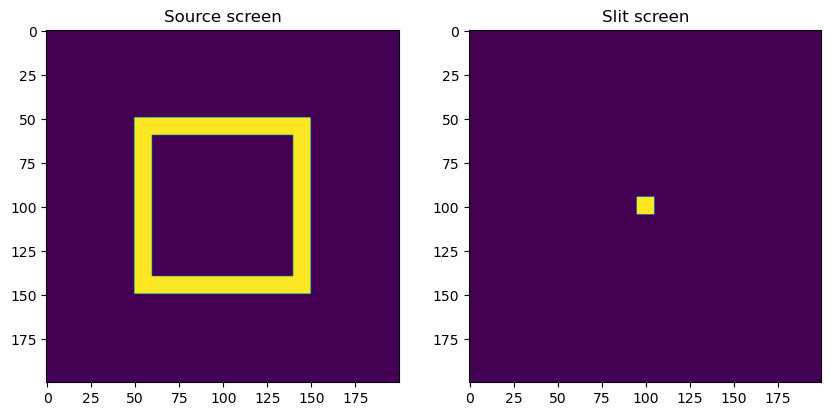

In [225]:
# Plot the source screen and the slit screen.
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(source_screen_mask)
plt.title('Source screen')
plt.subplot(1, 2, 2)
plt.imshow(slit_screen_mask)
plt.title('Slit screen')
plt.show()

In [235]:
sensor_screen = make_image(
    n_photons,
    source_resolution,
    source_screen_mask,
    slit_screen_mask,
    sensor_screen,
    pixel_sepatation,
    source_to_slit_distance,
    source_to_sensor_distance,
)

100%|██████████| 5000/5000 [03:12<00:00, 25.93it/s]


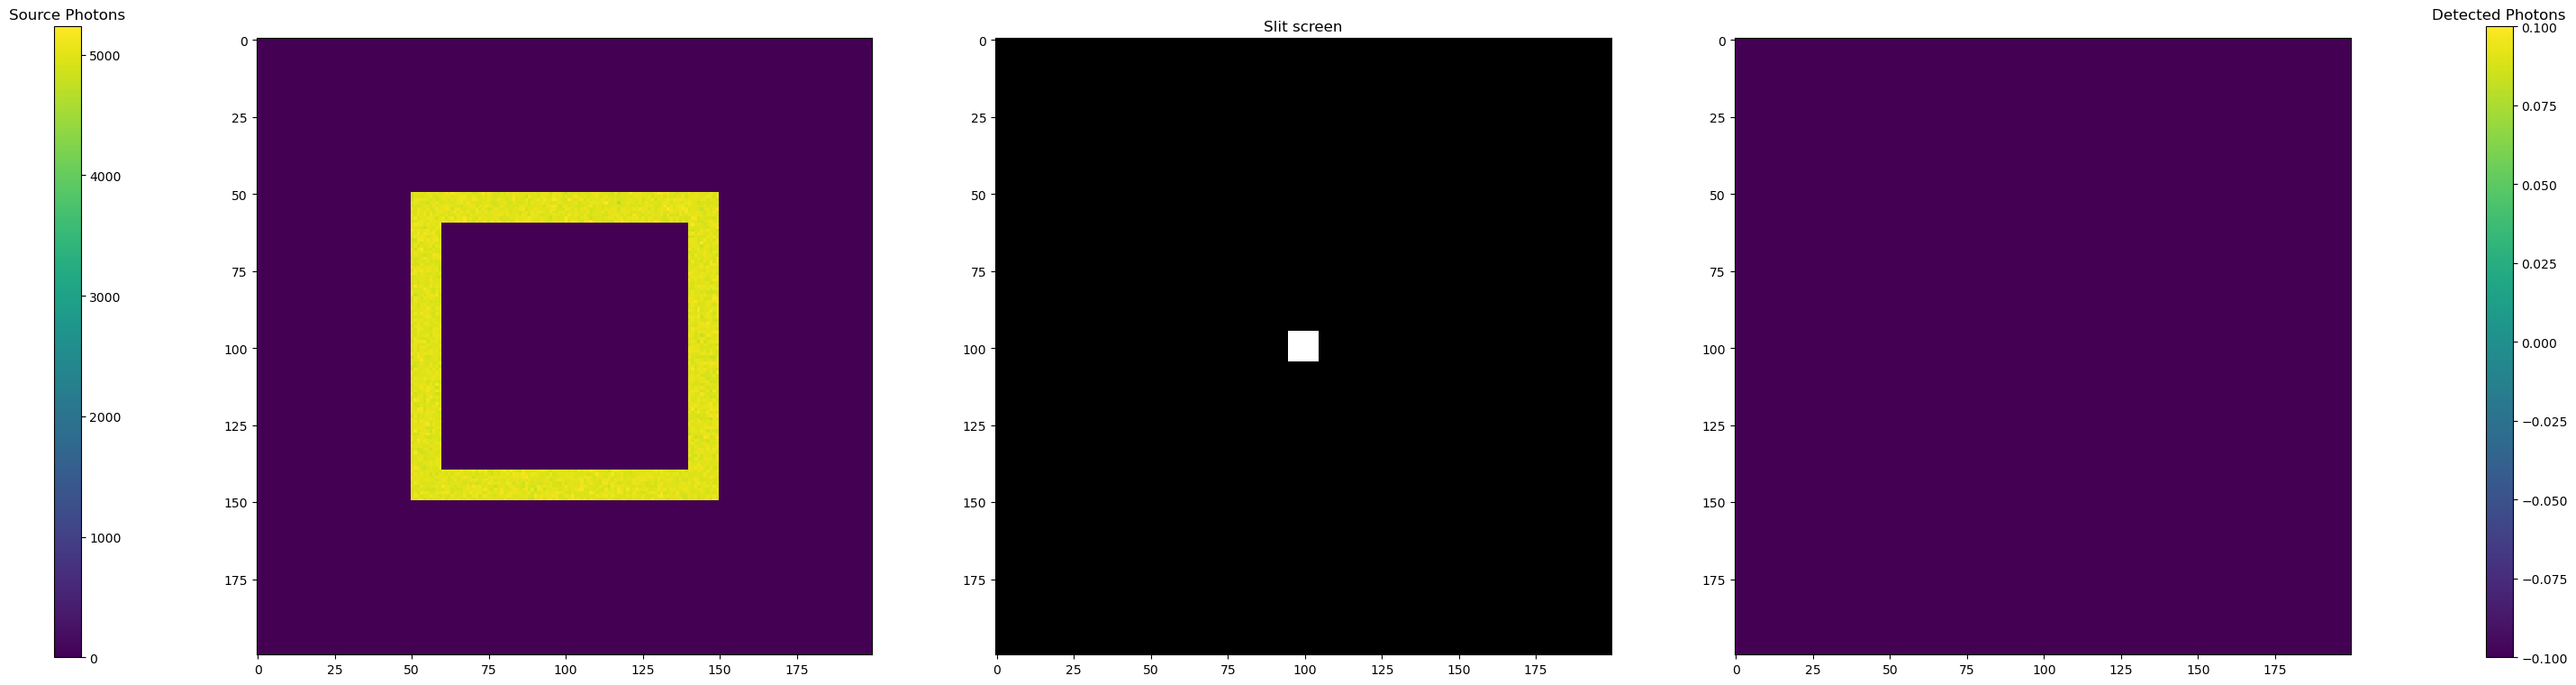

In [228]:
# Plot heatmap of the source screen, slit screen and sensor.
# Plot only one bar for all the plots.
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
vmin, vmax = 0, float(np.max(source_screen))
im = plt.imshow(source_screen, vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.05, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.title('Source Photons')
plt.subplot(1, 3, 2)
plt.imshow(slit_screen_mask, cmap='binary_r')
plt.title('Slit screen')
plt.subplot(1, 3, 3)
vmin, vmax = 0, float(np.max(sensor_screen))
im = plt.imshow(sensor_screen, vmin=vmin, vmax=vmax)
plt.imshow(sensor_screen, vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.title('Detected Photons')
plt.show()